### Setting up a CNN to classify images according to given labels.
This notebook is for use in google collab.
It is based on the article "Convolutional Neural Network From Scratch" by Luis Fernando Torres (https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07), the code of the Noise2Void pipeline (https://github.com/juglab/n2v/tree/main) and the satellite classification project by Ibai Irastorza (https://github.com/batxes/DL-Satellite-picture-classification-project).

In [1]:
#installing missing dependencies

!pip install -q catboost
!pip install -q optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.2 MB/s eta 0:00:00


In [2]:
# Importing Keras
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from keras.layers import Activation                          # Layer for activation functions
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from keras.models import load_model                          # This helps us to load trained models
# Preprocessing layers
from keras.layers import Rescaling                           # This layer rescales pixel values

# Importing TensorFlow
import tensorflow as tf

In [3]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
import csv
import time
from skimage import io
from datetime import datetime
from pip._internal.operations.freeze import freeze
import subprocess
import shutil

# Efficient Looping
import itertools

# Traceback for diagnosis
import traceback

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest
import math
from random import randrange

# Feature Selection
from sklearn.feature_selection import (
    RFECV, SelectKBest, chi2, f_classif, f_regression,
    mutual_info_classif, mutual_info_regression
)

# Machine Learning Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin,ClassifierMixin

# Preprocessing data
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer, FunctionTransformer

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Model Selection for Cross Validation
from sklearn.model_selection import (
    StratifiedKFold, KFold,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, TimeSeriesSplit
)

# Machine Learning metrics
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    cohen_kappa_score,
    make_scorer,
    roc_curve,
    auc,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)

# ML regressors
from sklearn.linear_model import HuberRegressor,RANSACRegressor, TheilSenRegressor, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.ensemble import (
    HistGradientBoostingRegressor, StackingRegressor,
    AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, StackingRegressor, VotingRegressor
    )
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# ML classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import (
    HistGradientBoostingClassifier, AdaBoostClassifier,
    RandomForestClassifier, GradientBoostingClassifier,
    StackingClassifier, VotingClassifier,ExtraTreesClassifier
    )
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Clustering algorithms
from sklearn.cluster import KMeans

# Fine-tuning
import optuna

# Randomizer
import random

# Encoder of categorical variables
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# OS
import os

# Image package
from PIL import Image

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




In [4]:
# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print('\nGPU Found! Using GPU...')
        !nvidia-smi
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)


GPU Found! Using GPU...
Thu Feb  6 13:40:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P0             28W /   70W |     102MiB /  15360MiB |      2%      Default |
|                                         |                        |                  N/A |
+----------------------

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# create input parameter class

class TrainParams():
  def __init__(self):

    # data
    self.raw_data_folder = str
    self.path_training_data = str
    self.path_testing_data = str
    self.path_val_data = str
    self.output_path = str
    self.model_name = "model_name"
    self.model_file_extension = "keras"
    self.categories = list

    # training dataset parameters
    self.labels = 'inferred'
    self.image_size = (256, 256)
    self.batch_size = 128
    self.validation_split = 0.2
    self.crop_to_aspect_ratio = True
    self.shuffle = True
    self.shuffle_seed = 1
    self.label_mode = 'categorical'

    #training paramters
    self.number_of_filters = 32
    self.numer_of_epochs = 100
    self.initial_learning_rate = 0.0001
    self.data_augmentation = True
    self.activation_function_learning = "relu"
    self.loss_function = "categorical_crossentropy"
    self.use_pretrained_model = False
    self.pretrained_model_path = str

# Loading training, testing, and validation directories
params = TrainParams()
params.model_name = "sat_030225"
params.model_file_extension = "keras"
params.output_path = '/content/drive/MyDrive/sat_classifyer/'
params.raw_data_folder = "/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/"
params.path_training_data = '/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train'
params.path_testing_data = '/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/test'
params.path_val_data = '/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/val'
params.categories = ["AnnualCrop","Forest","HerbaceousVegetation","Highway","Industrial","Pasture","PermanentCrop","Residential","River","SeaLake"]
params.batch_size = 128
params.validation_split = 0

AnnualCrop


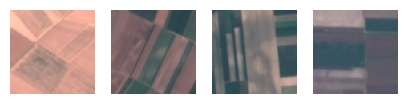

Forest


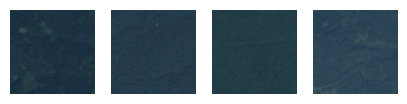

HerbaceousVegetation


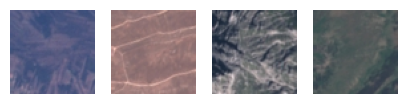

Highway


In [ ]:
path = "/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/"
target_size = (64, 64)
classes = params.categories

# lets check some images:
n_lines = 3
for m,class_ in enumerate(classes):
    fig,axs = plt.subplots(1, 4, figsize=(5, 10))
    print (class_)
    for n in range(4):
        example = "{}/{}_{}.jpg".format(class_,class_,randrange(1000))
        axs[n].imshow(load_img("{}{}".format(path,example), target_size=target_size))
        axs[n].axis("off")
    plt.pause(0.1)



In [ ]:
#create data folders, then split randomly and copy images into train/test/validation (60/20/20%)


for class_ in params.categories:
    images = os.listdir(os.path.join(params.raw_data_folder, class_))
    print("Type of image: %20s: %d images on folder." % (class_, len(images)))


Type of image:           AnnualCrop: 3000 images on folder.
Type of image:               Forest: 3000 images on folder.
Type of image: HerbaceousVegetation: 3000 images on folder.
Type of image:              Highway: 2500 images on folder.
Type of image:           Industrial: 2500 images on folder.
Type of image:              Pasture: 2022 images on folder.
Type of image:        PermanentCrop: 2500 images on folder.
Type of image:          Residential: 3000 images on folder.
Type of image:                River: 2500 images on folder.
Type of image:              SeaLake: 3000 images on folder.


In [ ]:
for folder in [params.path_training_data, params.path_testing_data, params.path_val_data]:
    for class_ in params.categories:
        directory = os.path.join(folder, class_)
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"{directory} created.")
        else:
          print(f"{directory} already existed.")

/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/AnnualCrop created.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/Forest created.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/HerbaceousVegetation created.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/Highway created.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/Industrial created.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/Pasture created.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/PermanentCrop created.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/Residential created.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/River created.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/SeaLake created.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/test/AnnualCrop created.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/test/Forest created.
/content/drive/MyDrive/sat_classifyer/

In [ ]:
paths = [params.path_training_data, params.path_testing_data, params.path_val_data]

np.random.seed(1)
class_dict = {}
for class_ in params.categories:
    images = os.listdir(os.path.join(params.raw_data_folder, class_))
    for image in images:
        class_dict[image] = class_

    list_train_80, list_test = train_test_split(images, test_size=0.2, random_state=1)
    list_train, list_val = train_test_split(list_train_80, test_size=0.25, random_state=1)
    print (class_)
    print (len(list_train),len(list_test),len(list_val))
    for image in list_train:
        shutil.copyfile(os.path.join(params.raw_data_folder, class_, image),os.path.join(params.path_training_data, class_, image))
    for image in list_test:
        shutil.copyfile(os.path.join(params.raw_data_folder, class_, image),os.path.join(params.path_testing_data, class_, image))
    for image in list_val:
        shutil.copyfile(os.path.join(params.raw_data_folder, class_, image),os.path.join(params.path_val_data, class_, image))


['AnnualCrop_675.jpg', 'AnnualCrop_2812.jpg', 'AnnualCrop_773.jpg', 'AnnualCrop_2985.jpg', 'AnnualCrop_37.jpg', 'AnnualCrop_899.jpg', 'AnnualCrop_2912.jpg', 'AnnualCrop_810.jpg', 'AnnualCrop_545.jpg', 'AnnualCrop_2024.jpg', 'AnnualCrop_800.jpg', 'AnnualCrop_514.jpg', 'AnnualCrop_568.jpg', 'AnnualCrop_36.jpg', 'AnnualCrop_229.jpg', 'AnnualCrop_377.jpg', 'AnnualCrop_950.jpg', 'AnnualCrop_2226.jpg', 'AnnualCrop_2004.jpg', 'AnnualCrop_2813.jpg', 'AnnualCrop_671.jpg', 'AnnualCrop_65.jpg', 'AnnualCrop_2417.jpg', 'AnnualCrop_2751.jpg', 'AnnualCrop_2312.jpg', 'AnnualCrop_391.jpg', 'AnnualCrop_2002.jpg', 'AnnualCrop_51.jpg', 'AnnualCrop_2246.jpg', 'AnnualCrop_2645.jpg', 'AnnualCrop_861.jpg', 'AnnualCrop_2666.jpg', 'AnnualCrop_2479.jpg', 'AnnualCrop_2930.jpg', 'AnnualCrop_2320.jpg', 'AnnualCrop_983.jpg', 'AnnualCrop_586.jpg', 'AnnualCrop_797.jpg', 'AnnualCrop_3000.jpg', 'AnnualCrop_27.jpg', 'AnnualCrop_2990.jpg', 'AnnualCrop_2565.jpg', 'AnnualCrop_2297.jpg', 'AnnualCrop_2876.jpg', 'AnnualCrop_24

In [ ]:
# Giving names to each directory
directories = {
    params.path_training_data: 'Train',
    params.path_testing_data: 'Test',
    params.path_val_data: 'Validation'
    }

# Naming subfolders
subfolders = params.categories

print('\n* * * * * Number of files in each folder * * * * *\n')

# Counting the total of pictures inside each subfolder and directory
for dir, name in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)


* * * * * Number of files in each folder * * * * *


Train/AnnualCrop: 1800

Train/Forest: 1800

Train/HerbaceousVegetation: 1800

Train/Highway: 1500

Train/Industrial: 1500

Train/Pasture: 1212

Train/PermanentCrop: 1500

Train/Residential: 1800

Train/River: 1500

Train/SeaLake: 1800

  Total: 16212
--------------------------------------------------------------------------------

Test/AnnualCrop: 600

Test/Forest: 600

Test/HerbaceousVegetation: 600

Test/Highway: 500

Test/Industrial: 500

Test/Pasture: 405

Test/PermanentCrop: 500

Test/Residential: 600

Test/River: 500

Test/SeaLake: 600

  Total: 5405
--------------------------------------------------------------------------------

Validation/AnnualCrop: 600

Validation/Forest: 600

Validation/HerbaceousVegetation: 600

Validation/Highway: 500

Validation/Industrial: 500

Validation/Pasture: 405

Validation/PermanentCrop: 500

Validation/Residential: 600

Validation/River: 500

Validation/SeaLake: 600

  Total: 5405
-----------

In [ ]:
# check if files have the same file size (if so we can assume they have the same dimensions and bit depth)

file_size_before = 0
file_size_now = 0

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)
        for i, file in enumerate(os.listdir(folder_path)):
          image_path = os.path.join(folder_path, file)
          print(image_path)
          if i <= 1:
            file_size_before = os.path.getsize(image_path)
            file_size_now = file_size_before
          else:
            file_size_now = os.path.getsize(image_path)
          if file_size_before == file_size_now:
            file_size_before = file_size_now
          else:
            print(f"At least two files in the folder {folder_path} have different dimensions or bit depth.")
            break


/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/AnnualCrop/AnnualCrop_1011.jpg
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/AnnualCrop/AnnualCrop_2729.jpg
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/AnnualCrop/AnnualCrop_1442.jpg
At least two files in the folder /content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/AnnualCrop have different dimensions or bit depth.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/Forest/Forest_2701.jpg
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/Forest/Forest_1314.jpg
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/Forest/Forest_2733.jpg
At least two files in the folder /content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/Forest have different dimensions or bit depth.
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/HerbaceousVegetation/HerbaceousVegetation_1570.jpg
/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB/train/HerbaceousVeg

In [7]:
# Creating a Dataset for the Training, Vaidation and Test data
def create_dataset(parameters, data):
  dataset = tf.keras.utils.image_dataset_from_directory(
      data,  # Directory where the Training images are located
      labels = params.labels, # Classes will be inferred according to the structure of the directory
      label_mode = params.label_mode,
      class_names = params.categories,
      batch_size = params.batch_size,    # Number of processed samples before updating the model's weights
      image_size = params.image_size, # Defining a fixed dimension for all images
      shuffle = params.shuffle,  # Shuffling data
      seed = params.shuffle_seed,  # Random seed for shuffling and transformations
      validation_split = params.validation_split, # create a validation set from the training set
      crop_to_aspect_ratio = params.crop_to_aspect_ratio # Resize images without aspect ratio distortion
      )
  return dataset


def calc_tensor_min_max(dataset):
  for img, label in dataset:
    min_max = (tf.reduce_min(img).numpy(), tf.reduce_max(img).numpy())
    return min_max

scaler = Rescaling(1./255) # Defining scaler values between 0 to 1


for purpose in ["train", "validation", "test"]:
  #create datase and directly rescale to range 0 to 1
  if purpose == "train":
    train = create_dataset(params, params.path_training_data)
    min_max_before = calc_tensor_min_max(train)
    train = train.map(lambda x, y: (scaler(x), y))
    min_max_after = calc_tensor_min_max(train)
    print(f"Created training dataset and normalised values from range {min_max_before} to range {min_max_after}")

  elif purpose == "validation":
    validation = create_dataset(params, params.path_val_data)
    min_max_before = calc_tensor_min_max(validation)
    validation = validation.map(lambda x, y: (scaler(x), y))
    min_max_after = calc_tensor_min_max(validation)
    print(f"Created validation dataset and normalised values from range {min_max_before} to range {min_max_after}")

  elif purpose == "test":
    test = create_dataset(params, params.path_testing_data)
    min_max_before = calc_tensor_min_max(test)
    test = test.map(lambda x, y: (scaler(x), y))
    min_max_after = calc_tensor_min_max(test)
    print(f"Created testing dataset and normalised values from range {min_max_before} to range {min_max_after}")


print('\nTraining Dataset:', train)
print('\nTesting Dataset:', test)
print('\nValidation Dataset:', validation)

Found 16212 files belonging to 10 classes.
Created training dataset and normalised values from range (21.625, 255.0) to range (0.085968144, 1.0)
Found 5405 files belonging to 10 classes.
Created validation dataset and normalised values from range (18.6875, 255.0) to range (0.076348044, 1.0)
Found 5405 files belonging to 10 classes.
Created testing dataset and normalised values from range (17.5625, 255.0) to range (0.09025736, 1.0)

Training Dataset: <_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

Testing Dataset: <_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

Validation Dataset: <_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [22]:
if params.data_augmentation:
  print("using data augmentation")
  # Creating data augmentation pipeline
  augmentation = tf.keras.Sequential(
      [
          tf.keras.layers.RandomRotation(
          factor = (-.25, .3),
          fill_mode = 'reflect',
          interpolation = 'bilinear',
          seed = params.shuffle_seed),


          tf.keras.layers.RandomBrightness(
          factor = (-.45, .45),
          value_range = (0.0, 1.0),
          seed = params.shuffle_seed),

          tf.keras.layers.RandomContrast(
          factor = (.5),
          seed = params.shuffle_seed)
      ]
  )

  augmentation.build((None, 256, 256, 3)) # Building model
  # Plotting model
  tf.keras.utils.plot_model(augmentation,
                            show_shapes = True,
                            show_layer_names = True,
                            expand_nested = True)

using data augmentation


In [23]:
# Initiating model on GPU

def create_model(params, strategy):
  with strategy.scope():
      model = Sequential()
      if params.data_augmentation:
          model.add(augmentation) # Adding data augmentation pipeline to the model

      # Feature Learning Layers
      model.add(Conv2D(params.number_of_filters, # Number of filters/Kernels
                      (3,3),               # Size of kernels (3x3 matrix)
                      strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                      padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input.
                      input_shape = (256,256,3) # Input image shape x,y,channels
                      ))
      model.add(Activation(params.activation_function_learning))# Activation function
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
      model.add(Dropout(0.2))

      model.add(Conv2D(64, (5,5), padding = 'same'))
      model.add(Activation(params.activation_function_learning))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
      model.add(Dropout(0.2))

      model.add(Conv2D(128, (3,3), padding = 'same'))
      model.add(Activation(params.activation_function_learning))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
      model.add(Dropout(0.3))

      model.add(Conv2D(256, (5,5), padding = 'same'))
      model.add(Activation(params.activation_function_learning))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
      model.add(Dropout(0.3))

      model.add(Conv2D(512, (3,3), padding = 'same'))
      model.add(Activation(params.activation_function_learning))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
      model.add(Dropout(0.3))

      # Flattening tensors
      model.add(Flatten())

      # Fully-Connected Layers
      model.add(Dense(2048))
      model.add(Activation(params.activation_function_learning))
      model.add(Dropout(0.5))

      # Output Layer
      model.add(Dense(len(params.categories), activation = 'softmax')) # Classification layer

      # Compiling model
      model.compile(optimizer = tf.keras.optimizers.RMSprop(params.initial_learning_rate), # 1e-4
                loss = params.loss_function, # Ideal for multiclass tasks
                metrics = ['accuracy']) # Evaluation metric
  return model


model = create_model(params, strategy)

In [24]:
# Defining an Early Stopping and Model Checkpoints
# early_stopping = EarlyStopping(monitor = 'val_accuracy',
#                               patience = 5, mode = 'max',
#                               restore_best_weights = True)

checkpoint_path = os.path.join(params.output_path, params.model_name, params.model_name + "." + params.model_file_extension)

checkpoint = ModelCheckpoint(checkpoint_path,
                            monitor = 'val_accuracy',
                            save_best_only = True)


In [25]:
# determine whether you wanna build on a previously trained model

if params.use_pretrained_model:
  model_file_path = os.path.join(params.pretrained_model_path)

# # If the model path chosen does not contain a pretrain model then use_pretrained_model is disabled,
  if not os.path.exists(model_file_path):
    print('WARNING: weights_last.h5 pretrained model does not exist')
    params.use_pretrained_model = False


  else:
#Here we check if the learning rate can be loaded from the quality control folder
    if os.path.exists(os.path.join(params.pretrained_model_path, 'Quality Control', 'training_evaluation.csv')):

      with open(os.path.join(params.pretrained_model_path, 'Quality Control', 'training_evaluation.csv'),'r') as csvfile:
        csvRead = pd.read_csv(csvfile, sep=',')
        #print(csvRead)

        if "learning rate" in csvRead.columns: #Here we check that the learning rate column exists
          print("pretrained network learning rate found")
          #find the last learning rate
          lastLearningRate = csvRead["learning rate"].iloc[-1]
          #Find the learning rate corresponding to the lowest validation loss
          min_val_loss = csvRead[csvRead['val_loss'] == min(csvRead['val_loss'])]
          #print(min_val_loss)
          bestLearningRate = min_val_loss['learning rate'].iloc[-1]

          if params.pretrained_weights_choice == "last":
            print('Last learning rate: '+str(lastLearningRate))

          if params.pretrained_weights_choice == "best":
            print('Learning rate of best validation loss: '+str(bestLearningRate))

        if not "learning rate" in csvRead.columns: #if the column does not exist, then initial learning rate is used instead
          bestLearningRate = params.initial_learning_rate
          lastLearningRate = params.initial_learning_rate
          print('WARNING: The learning rate cannot be identified from the pretrained network. Default learning rate of '+str(bestLearningRate)+' will be used instead')

#Compatibility with models trained outside ZeroCostDL4Mic but default learning rate will be used
    if not os.path.exists(os.path.join(params.pretrained_model_path, 'Quality Control', 'training_evaluation.csv')):
      print('WARNING: The learning rate cannot be identified from the pretrained network. Default learning rate of '+str(params.initial_learning_rate)+' will be used instead')
      bestLearningRate = params.initial_learning_rate
      lastLearningRate = params.initial_learning_rate


# Display info about the pretrained model to be loaded (or not)
if params.use_pretrained_model:
  print('Weights found in:')
  print(model_file_path)
  print('will be loaded prior to training.')
  model.load_weights(model_file_path)

else:
  print('No pretrained network will be used.')



No pretrained network will be used.


In [26]:
# train and save model and statistics

start = time.time()

history = model.fit(train, epochs = params.numer_of_epochs, validation_data = validation, callbacks = [checkpoint])

# convert the history.history dict to a pandas DataFrame:
lossData = pd.DataFrame(history.history)

if os.path.exists(params.output_path+"/"+params.model_name+"/Quality Control"):
  shutil.rmtree(params.output_path+"/"+params.model_name+"/Quality Control")

os.makedirs(params.output_path+"/"+params.model_name+"/Quality Control")

# The training evaluation.csv is saved (overwrites the Files if needed).
lossDataCSVpath = params.output_path+'/'+params.model_name+'/Quality Control/training_evaluation.csv'
with open(lossDataCSVpath, 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['loss','val_loss', 'learning rate'])
  for i in range(len(history.history['loss'])):
    writer.writerow([history.history['loss'][i], history.history['val_loss'][i], params.initial_learning_rate])

# Displaying the time elapsed for training
dt = time.time() - start
mins, sec = divmod(dt, 60)
hour, mins = divmod(mins, 60)
print("Time elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)")

# #Create a pdf document with training summary
# pdf_export(trained=True, pretrained_model = params.use_pretrained_model)

#save model
path = os.path.join(params.output_path, params.model_name, params.model_name + "." + params.model_file_extension)
model.save(path)

Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 4458s 4s/step - accuracy: 0.2735 - loss: 5.1833 - val_accuracy: 0.2006 - val_loss: 12.6941
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 175s 167ms/step - accuracy: 0.4328 - loss: 1.6738 - val_accuracy: 0.3267 - val_loss: 9.6512
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 165s 162ms/step - accuracy: 0.5166 - loss: 1.4450 - val_accuracy: 0.3142 - val_loss: 12.2628
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 166s 164ms/step - accuracy: 0.5655 - loss: 1.3145 - val_accuracy: 0.3382 - val_loss: 14.5521
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 203s 166ms/step - accuracy: 0.6011 - loss: 1.2159 - val_accuracy: 0.4030 - val_loss: 16.1116
Time elapsed: 1.0 hour(s) 26.0 min(s) 8 sec(s)


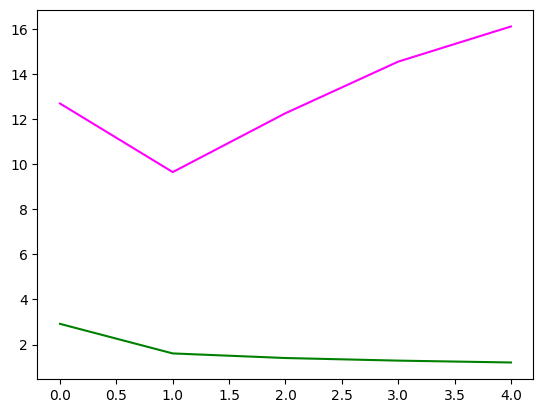

In [27]:
# plot from from memory
train_loss = plt.plot(list(range(len(history.history['loss']))),
                        history.history['loss'], color='green')

val_loss = plt.plot(list(range(len(history.history['val_loss']))),
                      history.history['val_loss'], color='magenta')


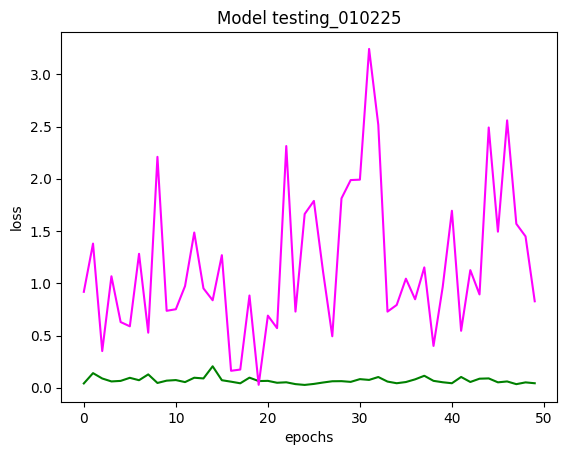

In [ ]:
# plot from from file
path_to_file = "/content/drive/MyDrive/cnn_from_scratch290125/010225/testing_010225/Quality Control/training_evaluation.csv"
train_stats = pd.read_csv(path_to_file)

plt.figure()
plt.title(f'Model {params.model_name}')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc="upper left")

train_loss = plt.plot(train_stats['loss'], color='green', label = "training loss")

val_loss = plt.plot(train_stats['val_loss'], color='magenta', label = "validation loss")


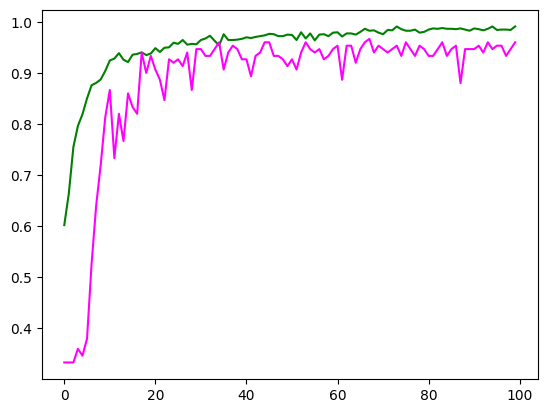

In [ ]:

# Accuray over epochs
train_acc = plt.plot(list(range(len(history.history['accuracy']))),
                       history.history['accuracy'], color = "green")
val_acc = plt.plot(list(range(len(history.history['val_accuracy']))),
                     history.history['val_accuracy'], color = "magenta")



In [ ]:
#tf.keras.utils.plot_model(model) # Plotting model

In [ ]:
model.summary() # Printing model summary

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,491,336 (528.30 MB)

 Trainable params: 69,244,675 (264.15 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 69,244,677 (264.15 MB)

In [ ]:
preds = model.predict(validation)  # Running model on the validation dataset
val_loss, val_acc = model.evaluate(validation) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

In [ ]:
# Loading an image from the Validation/ Powdery directory
image_path = '/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Powdery/9b6a318cc5721d73.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Powdery Plant: \n')
resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

In [ ]:
# Loading an image from the Validation/ Rust directory
image_path = '/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust/8152cfbd5a28b5d2.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Rust Plant: \n')
resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

In [ ]:
# Loading an image from the Validation/ Healthy directory
image_path = '/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9c99786a63786571.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Healthy Plant: \n')
resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')